In [2]:
#useful: https://github.com/fusion-flap/flap
import sys
sys.path.append('E:\marci main\Fusion\flap_module\flap')

import flap


import glob
import os
from scipy import io
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os
import numpy as np
from scipy import signal
import copy
import time
import math

import scipy.signal
import scipy.fftpack
import scipy.integrate
import matplotlib.colors as colors

## Loading NTI wavelet - sav file

In [3]:
path ='E:\\marci main\\Fusion\\inputdata\\in\\'#pc
#path ='C:\\Users\\win10\\Downloads\\transient-waves\\inputdata\\in\\'#laptop

for filename in glob.glob(os.path.join(path, '*.sav')):
    loaded_sav = io.readsav(filename, python_dict = True)
    print('Loaded: '+filename)
    print('\n')
    
for i in range(loaded_sav["channels"].size):
    tmp = str(loaded_sav["channels"][i])
    loaded_sav["channels"][i] = tmp[2:-1]

#print(loaded_sav["channels"])

print(list(loaded_sav))
#print(loaded_sav["theta"])
#print(loaded_sav['theta'].shape

Loaded: E:\marci main\Fusion\inputdata\in\AUGD_32326_MHA.sav


['expname', 'shotnumber', 'channels', 'data', 'timeax', 'theta', 'phi', 'data_history', 'coord_history']


## Creating coordinate axes

In [4]:
print(loaded_sav["timeax"])
time_ax = flap.Coordinate(name="Time",
                          unit="s",
                          mode = flap.CoordinateMode(equidistant=True),
                          start=loaded_sav["timeax"][0],
                          step=loaded_sav["timeax"][1]-loaded_sav["timeax"][0],
                          #values=loaded_sav["timeax"]
                          dimension_list=[1]
                         )

print(time_ax)
print(time_ax.unit.name)
print(time_ax.step)

[0.85      0.8500005 0.850001  ... 0.949999  0.9499995 0.95     ]
Time
[4.999999999588667e-07]


In [5]:
channel_name = flap.Coordinate(name="Channels",
                          unit=None,
                          mode = flap.CoordinateMode(equidistant=False),
                          values=loaded_sav["channels"],
                          dimension_list=[0],
                          shape = len(loaded_sav["channels"])
                         )

channel_no = flap.Coordinate(name="Channel_no",
                          unit="no",
                          mode = flap.CoordinateMode(equidistant=True),
                          start=0,
                          step=1,
                          dimension_list=[0]
                         )

theta_ax =flap.Coordinate(name="Theta",
                          unit="rad",
                          mode = flap.CoordinateMode(equidistant=False),
                          values=loaded_sav["theta"],
                          dimension_list=[0],
                          shape = len(loaded_sav["theta"])
                         )

phi_ax =flap.Coordinate(name="Phi",
                          unit="rad",
                          mode = flap.CoordinateMode(equidistant=False),
                          values=loaded_sav["phi"],
                          dimension_list=[0],
                          shape = len(loaded_sav["phi"])
                         )

print(channel_name.values)

['MHA-B31-14' 'MHA-B31-03' 'MHA-B31-01' 'MHA-B31-02' 'MHA-B31-12'
 'MHA-B31-13' 'MHA-C04-01' 'MHA-C09-01_' 'MHA-B31-11' 'MHA-B31-10'
 'MHA-B31-09' 'MHA-B31-08' 'MHA-B31-07' 'MHA-B31-06' 'MHA-B31-05'
 'MHA-B31-30' 'MHA-C39-01' 'MHA-C09-26' 'MHA-C09-01' 'MHA-C09-02'
 'MHA-C09-03' 'MHA-C09-04' 'MHA-C09-05' 'MHA-C09-06']


## Creating and slicing flap dataobject

In [6]:
flap_object= flap.DataObject(
                      data_array = loaded_sav['data'],
                      data_unit = flap.Unit(name= 'voltage', unit= 'volt'),
                      exp_id = str(loaded_sav['expname'])[2:-1]+" "+str(loaded_sav['shotnumber']),
                      coordinates = [time_ax,channel_name,channel_no,theta_ax,phi_ax],
                      data_shape=loaded_sav['data'].shape
                     )

print(flap_object.exp_id)
flap_object.coordinate('Time')

AUGD 32326


(array([[0.85     , 0.8500005, 0.850001 , ..., 0.949999 , 0.9499995,
         0.95     ],
        [0.85     , 0.8500005, 0.850001 , ..., 0.949999 , 0.9499995,
         0.95     ],
        [0.85     , 0.8500005, 0.850001 , ..., 0.949999 , 0.9499995,
         0.95     ],
        ...,
        [0.85     , 0.8500005, 0.850001 , ..., 0.949999 , 0.9499995,
         0.95     ],
        [0.85     , 0.8500005, 0.850001 , ..., 0.949999 , 0.9499995,
         0.95     ],
        [0.85     , 0.8500005, 0.850001 , ..., 0.949999 , 0.9499995,
         0.95     ]]), None, None)

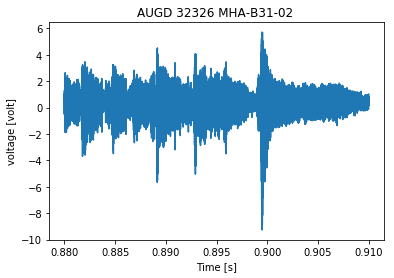

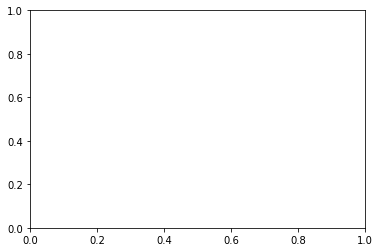

In [7]:
slicing_channel = 'MHA-B31-02'
sliced_object = flap_object.slice_data(slicing={"Channels":slicing_channel}).slice_data(slicing={"Time":flap.Intervals(0.88,0.91)})
sliced_object.exp_id = sliced_object.exp_id +" "+ slicing_channel

plt1 =sliced_object.plot()
#flap_object.plot(plot_type = 'multi xy')
#plt1.ylim(-6,2)
#flap.list_data_objects(sliced_object)

## Creating spectogram

In [8]:
min_t=min(sliced_object.coordinate('Time')[0])
max_t=max(sliced_object.coordinate('Time')[0])
t = max_t-min_t
print(t)
s=sliced_object.data
samples = np.size(sliced_object.data)
s_rate=samples/t

nyquist=samples/2/t
frangemax=nyquist#200#

0.029999499997532042


Calculating STFT...
Calculating STFT...


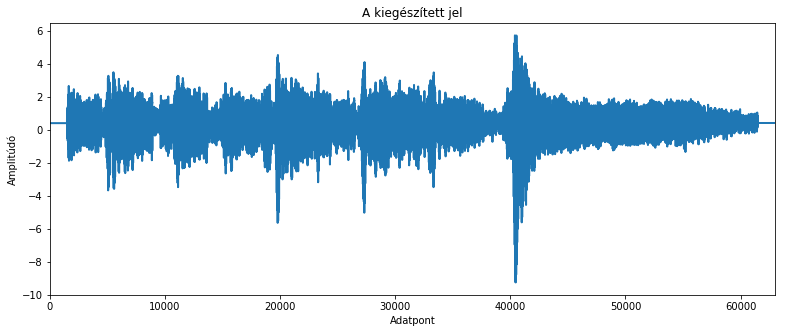

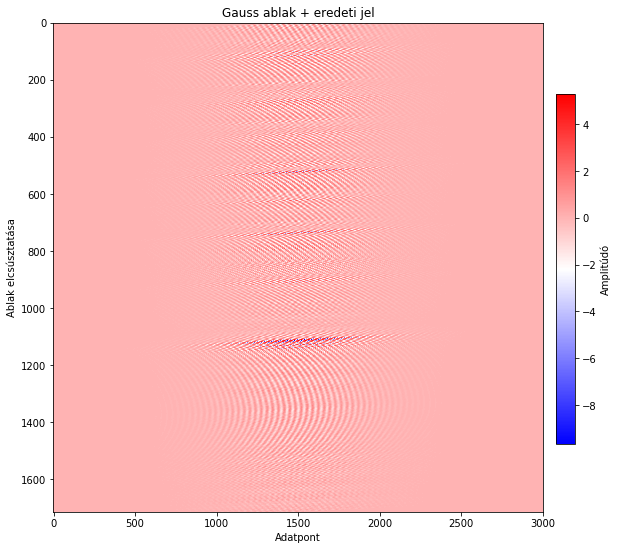

In [9]:
win_r = 1500 #1000
d_win=35#random.randint(200,300)
std=300 #150
win_base = scipy.signal.gaussian(2*win_r+1, std=std)#np.wining(2*win_r+1)

z_padded_s = np.zeros (samples+2*win_r)
z_padded_s[win_r:-win_r] = s
z_padded_s[0:win_r]=np.average(z_padded_s[win_r+1:2*win_r])
z_padded_s[-win_r:]=np.average(z_padded_s[-2*win_r:-win_r-1])
x_win=np.linspace(0.0, t+(2*win_r/s_rate), samples+2*win_r)

plt.figure(figsize=(13,5))
plt.plot(z_padded_s,"-",linewidth = 2)#x_win,idő (s),max(x_win)
plt.xlim((0,samples+2*win_r))
plt.title('A kiegészített jel')
plt.xlabel('Adatpont')
plt.ylabel('Amplitúdó')
plt.savefig('sxr2_p.pdf')
#plt.show()

win = np.zeros((int(samples/d_win+1), 2*win_r+1))
for i in range(int(samples/d_win+1)):
    win [i]=win_base

z_win = np.zeros((int(samples/d_win+0.9), win_r*2+1))
for i in range(int(samples/d_win+0.9)):
    if i<1000001:
        z_win[i] = win[i] * (z_padded_s [d_win*i:d_win*i+win_r+win_r+1]-np.average(z_padded_s [d_win*i:d_win*i+win_r+win_r+1]))
    #z_win[i] = win[i] * (z_padded_s [d_win*i:d_win*i+win_r+win_r+1])

plt.figure(figsize=(9,9))
plt.imshow(z_win,aspect='auto',cmap='bwr')#, extent=(min_t*s_rate/d_win,max_t*s_rate/d_win,max_t*s_rate,min_t*s_rate)
plt.title('Gauss ablak + eredeti jel')
plt.xlabel('Adatpont')
plt.ylabel('Ablak elcsúsztatása')
plt.subplots_adjust(right=0.88)
cax = plt.axes([0.90, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig('z_win.pdf')
#plt.show()

z_win_fft = np.zeros((int(samples/d_win+0.9), win_r*2+1))
for i in range(int(samples/d_win+0.9)):
    if i % 1000 == 0:
        print('Calculating STFT...')
    if i<1000001:
        z_win_fft[i] = np.abs(scipy.fftpack.fft(z_win[i]))**2

Requested? feature: refer to coodrinate with name (not using a for loop)

In [10]:
stft_ax=copy.deepcopy(sliced_object.coordinates)

for c in stft_ax:
    if c.unit.name == 'Time':
        c.step = sliced_object.coordinates[0].step[0]*d_win
        break

stft_ax.append(flap.Coordinate(name="Frequency",
                          unit="kHz",
                          mode = flap.CoordinateMode(equidistant=True),
                          start=0.0,  #,
                          step=s_rate/(2*win_r+1)/1000,  #
                          dimension_list=[1]
                         ))

stft_object = flap.DataObject(
                      data_array = z_win_fft,
                      data_unit = flap.Unit(name= 'Power', unit= 'W'),
                      exp_id = str(loaded_sav['expname'])[2:-1],
                      coordinates = stft_ax, #[stft_ax[0],stft_ax[-1]],
                      data_shape=z_win_fft.shape
                     )

flap.list_data_objects(stft_object)


-----------------------------
<1>(data_source:"" exp_id:"AUGD") data_title:"" shape:[1715,3001][no error]
  Data name:"Power", unit:"W"
  Coords:
    'Time [s](Dims:0]) [<Equ.><R. symm.>] Start:  8.800E-01, Steps:  1.750E-05
    'Channels [a.u.](Dims:, Shape:[1]) [<R. symm.>] Val:MHA-B31-02
    'Channel_no [no](Dims:, Shape:[1]) [<R. symm.>] Val:3
    'Theta [rad](Dims:, Shape:[1]) [<R. symm.>] Val: 6.181E+00
    'Phi [rad](Dims:, Shape:[1]) [<R. symm.>] Val: 5.184E+00
    'Frequency [kHz](Dims:1]) [<Equ.><R. symm.>] Start:  0.000E+00, Steps:  6.665E-01


'\n-----------------------------\n<1>(data_source:"" exp_id:"AUGD") data_title:"" shape:[1715,3001][no error]\n  Data name:"Power", unit:"W"\n  Coords:\n    \'Time [s](Dims:0]) [<Equ.><R. symm.>] Start:  8.800E-01, Steps:  1.750E-05\n    \'Channels [a.u.](Dims:, Shape:[1]) [<R. symm.>] Val:MHA-B31-02\n    \'Channel_no [no](Dims:, Shape:[1]) [<R. symm.>] Val:3\n    \'Theta [rad](Dims:, Shape:[1]) [<R. symm.>] Val: 6.181E+00\n    \'Phi [rad](Dims:, Shape:[1]) [<R. symm.>] Val: 5.184E+00\n    \'Frequency [kHz](Dims:1]) [<Equ.><R. symm.>] Start:  0.000E+00, Steps:  6.665E-01'

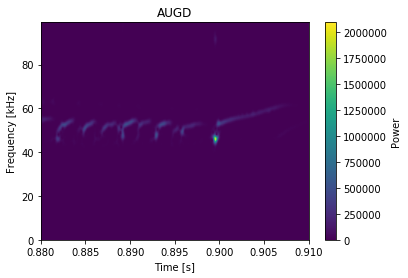

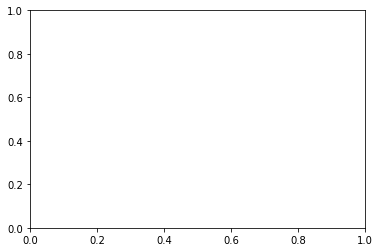

In [11]:
plot = stft_object.slice_data(slicing={"Frequency":flap.Intervals(0,100)}).plot(axes = ['Time','Frequency'], plot_type = 'image')

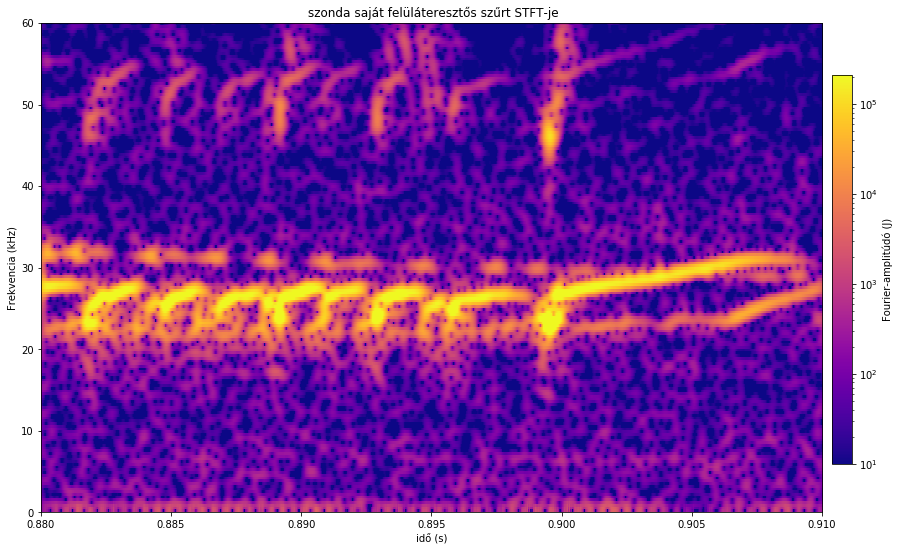

In [12]:
#%%script false
shot = ""

colornorm=colors.LogNorm(vmin=z_win_fft.min()*40000000, vmax=z_win_fft.max()/10)
logax = np.linspace(int(np.log10(z_win_fft.min())),int(np.log10(z_win_fft.max())),int(np.log10(z_win_fft.max()))-int(np.log10(z_win_fft.min()))+1)
logax = 10**logax
fig, ax = plt.subplots(figsize=(14,9))
img = plt.imshow(np.transpose(z_win_fft),cmap='plasma',  aspect='auto', extent=[min_t,max_t,nyquist/1000,0], norm=colornorm)#interpolation='gaussian',*30000000/4
#plt.title('39424-es kisülés, J051-es szonda STFT-je')
plt.title(shot+' szonda saját felüláteresztős szűrt STFT-je')
#plt.title('AUGD 34924, B31-40-es szonda STFT-je')
plt.ylabel('Frekvencia (kHz)')
plt.xlabel('idő (s)')#('time (s)')
plt.ylim(0,60)
#plt.xlim(1.9,2.4)
plt.subplots_adjust(right=0.90)
#plt.gca().invert_yaxis()
cbar=plt.colorbar(img,cax=plt.axes([0.91, 0.2, 0.02, 0.6]),ticks=None)
cbar.set_label('Fourier-amplitúdó (J)')
#cbar.set_ticks(logax)
plt.savefig(shot+' '+str(min_t)+'-'+str(max_t)+' stft.pdf')#34924_40
plt.show()

#change plt to custom plotid

In [13]:
print(sliced_object.coordinate('Time'))
print(stft_object.coordinate('Time'))

(array([0.88     , 0.8800005, 0.880001 , ..., 0.9099985, 0.909999 ,
       0.9099995]), None, None)
(array([[0.88     , 0.88     , 0.88     , ..., 0.88     , 0.88     ,
        0.88     ],
       [0.8800175, 0.8800175, 0.8800175, ..., 0.8800175, 0.8800175,
        0.8800175],
       [0.880035 , 0.880035 , 0.880035 , ..., 0.880035 , 0.880035 ,
        0.880035 ],
       ...,
       [0.90996  , 0.90996  , 0.90996  , ..., 0.90996  , 0.90996  ,
        0.90996  ],
       [0.9099775, 0.9099775, 0.9099775, ..., 0.9099775, 0.9099775,
        0.9099775],
       [0.909995 , 0.909995 , 0.909995 , ..., 0.909995 , 0.909995 ,
        0.909995 ]]), None, None)


**Warning/ERROR: plot changes when coordinate start is 0 or 0.0 (int or double)**

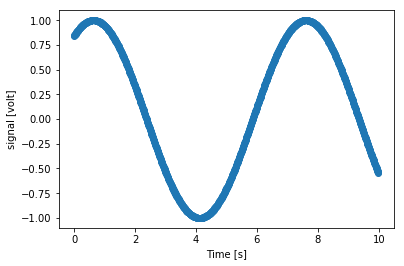

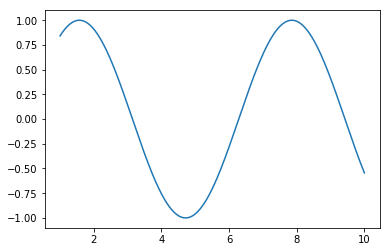

In [14]:
time_dummy = flap.Coordinate(name="Time",
                          unit="s",
                          mode = flap.CoordinateMode(equidistant=True),
                          start=0.0,
                          step=0.01,
                          #values=np.linspace(1,5,10)
                          dimension_list=[0]
                         )

data_array = np.sin(np.linspace(start=1,stop=10,num=1000))
x = np.linspace(start=1,stop=10,num=1000)

dummy= flap.DataObject(data_array = data_array,
                       data_unit = flap.Unit(name = "signal",unit = "volt"),#
                       coordinates = time_dummy,  #,value_dummy]
                       data_shape=data_array.shape
                     )

dummy.plot(plot_type = 'scatter')
plt.plot(x,data_array)